In [12]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import keras.backend as K
from keras.optimizers import Adam
import keras
import h5py as h5py
import cython
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [13]:
import os
os.getcwd()
os.chdir('D:\Stanford\CS230\Project')
os.getcwd()

'D:\\Stanford\\CS230\\Project'

In [14]:
eurusd_data = pd.read_excel('EURUSDTS.xlsx')
raw_data = eurusd_data.dropna()
#Convert to scales between 0 and 1
raw_data.date = pd.to_datetime(raw_data.date)
raw_data_inx = raw_data.set_index(["date"], drop=True)
raw_data_inx = raw_data_inx.rename(columns = {' value':'value'})
raw_data_inx = raw_data_inx.iloc[::-1]

In [15]:
#We only model on the EURUSD price on the RNN model
price = raw_data_inx[['value']]

In [16]:
splitdate = pd.Timestamp('01-01-2016')
train_data = price.loc[:splitdate]
test_data = price.loc[splitdate:]

In [17]:
train_data_scaled = train_data.apply(minmax_scale)
test_data_scaled = test_data.apply(minmax_scale)

In [18]:
X_train = train_data_scaled[:-1]
y_train = train_data_scaled[1:]

X_test = test_data_scaled[:-1]
y_test = test_data_scaled[1:]

In [19]:
#To apply the RNN, we need to convert the data into 3D
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [20]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(12, input_shape=(1, X_train.shape[1]), activation='relu', 
                    kernel_initializer='lecun_uniform', return_sequences=False))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_test_lstm)
y_train_pred_lstm = model_lstm.predict(X_train_lstm)

Epoch 1/200
1201/1201 [==============================] - 3s 3ms/step - loss: 0.0039
Epoch 2/200
1201/1201 [==============================] - 3s 2ms/step - loss: 7.6549e-04
Epoch 3/200
1201/1201 [==============================] - 2s 2ms/step - loss: 7.0979e-04
Epoch 4/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.8459e-04
Epoch 5/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.6703e-04
Epoch 6/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.5128e-04
Epoch 7/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.3878e-04
Epoch 8/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.3008e-04
Epoch 9/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.2142e-04
Epoch 10/200
1201/1201 [==============================] - 2s 2ms/step - loss: 6.0800e-04
Epoch 11/200
1201/1201 [==============================] - 2s 2ms/step - loss: 5.9705e-04
Epoch 12/200
1201/1201 [==========

In [36]:
model_lstm.save('LSTM_EURUSD.h5')

In [37]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_lstm = load_model('LSTM_EURUSD.h5')
score_lstm= model_lstm.evaluate(X_test_lstm, y_test, batch_size=1)

4287/4287 [==============================] - 3s 740us/step


In [39]:
y_pred_test_LSTM = model_lstm.predict(X_test_lstm)
y_test_reset = y_test.reset_index()
y_true = y_test.value.to_numpy()

In [40]:
col1 = pd.DataFrame(y_true, columns=['True'])
col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)

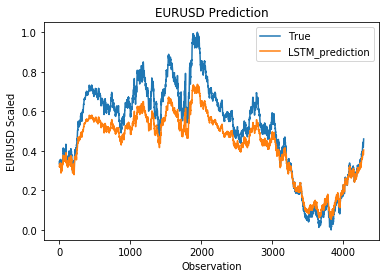

In [41]:
plt.plot(results['True'], label='True')
plt.plot(results['LSTM_prediction'], label='LSTM_prediction')
plt.title("EURUSD Prediction")
plt.xlabel('Observation')
plt.ylabel('EURUSD Scaled')
plt.legend()
plt.show()